# Identify hidden genes using the orthology table

Distinguish hidden gene from a missing gene: a hidden gene is present in at least one organism of a class, but not in all of them.

**Input:** Orthology table (.xsl, .csv, .tsv), version of Ensembl compara used

**Output:** A list of hidden genes, a list of organism with these genes missing (dict gene:list of organisms), a list of organisms with these genes present (dict structure gene:list of organisms)

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import json
import seaborn as sns
import gget
from Bio.SeqUtils import GC
import pathlib

In [2]:
ens_api = "https://rest.ensembl.org"

In [3]:
ensemble_release = 109

## Orthology table preprocessing

In [4]:
def get_orthology_table(table_dir: str, table_name: str):
    table_file = pathlib.Path(table_dir) / table_name
    file_type = table_file.suffix
    if file_type == ".csv":
        return pd.read_csv(table_file, sep=",", header=0, index_col=0, low_memory=False)
    elif file_type == ".tsv":
        return pd.read_csv(table_file, sep="\t", header=0, index_col=0, low_memory=False)
    elif (file_type == ".xsls") or (file_type == ".xsl"):
        return pd.read_excel(table_file, header=0, index_col=0, low_memory=False)
    else:
        print("Accepted file formats: .csv, .tsv, .xsls, .xsl!")

In [5]:
# upload the orthology table
orthology_df = get_orthology_table("orthology_table", "orthology_table-68species_ensembl_ids.csv")
orthology_df

,Homo sapiens,Cricetulus griseus,Mesocricetus auratus,Rattus norvegicus,Cavia porcellus,Octodon degus,Heterocephalus glaber,Maylandia zebra,Pteropus vampyrus,Monodelphis domestica,...,Felis catus,Tursiops truncatus,Loxodonta africana,Equus caballus,Bos taurus,Capra hircus,Ovis aries,Ochotona princeps,Oryctolagus cuniculus,Tetraodon nigroviridis
0,ENSG00000167103,ENSCGRG00001009175,NaN,ENSRNOG00000048676,ENSCPOG00000005283,ENSODEG00000003703,ENSHGLG00000018036,ENSMZEG00005000701,ENSPVAG00000000967,NaN,...,ENSFCAG00000001492,ENSTTRG00000016470,ENSLAFG00000000585,NaN,ENSBTAG00000003387,ENSCHIG00000020199,ENSOARG00020015289,ENSOPRG00000016354,ENSOCUG00000026071,NaN
1,ENSG00000258873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSPVAG00000003020,NaN,...,NaN,ENSTTRG00000014200,ENSLAFG00000030167,ENSECAG00000043636,NaN,NaN,NaN,ENSOPRG00000000440,NaN,NaN
2,ENSG00000213088,ENSCGRG00001021594,ENSMAUG00000015131,ENSRNOG00000069330,ENSCPOG00000024213,ENSODEG00000009370,ENSHGLG00000006136,NaN,NaN,ENSMODG00000042514,...,ENSFCAG00000018619,NaN,ENSLAFG00000031828,ENSECAG00000000874,ENSBTAG00000003220,ENSCHIG00000003089,ENSOARG00020009415,ENSOPRG00000018458,NaN,NaN
3,ENSG00000185245,NaN,NaN,ENSRNOG00000025959,NaN,NaN,NaN,NaN,ENSPVAG00000003789,ENSMODG00000005365,...,ENSFCAG00000008042,ENSTTRG00000001296,ENSLAFG00000032715,ENSECAG00000040351,ENSBTAG00000004909,NaN,ENSOARG00020025177,NaN,ENSOCUG00000001099,NaN
4,ENSG00000198870,ENSCGRG00001004554,ENSMAUG00000013976,ENSRNOG00000027911,ENSCPOG00000021170,ENSODEG00000015481,ENSHGLG00000016873,NaN,ENSPVAG00000001428,ENSMODG00000012800,...,ENSFCAG00000003766,ENSTTRG00000007671,ENSLAFG00000008238,ENSECAG00000022240,ENSBTAG00000004140,NaN,ENSOARG00020002366,ENSOPRG00000001115,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSTNIG00000020644
54117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSTNIG00000020257


In [6]:
# add class info to the orthology table

def get_list_organisms_orthology_table(orth_df: pd.DataFrame):
    # get a list column labels
    column_names = orth_df.columns.tolist()
    # convert species name to lowercase (useful for ensemble rest api)
    organism_names = [x.lower().replace(" ", "_") for x in column_names]
    organism_names = list(map(lambda x: x.replace("heterocephalus_glaber", "heterocephalus_glaber_female"), organism_names))
    organism_names = list(map(lambda x: x.replace("gorilla_gorilla_gorilla", "gorilla_gorilla"), organism_names))
    organism_names = list(map(lambda x: x.replace("cricetulus_griseus", "cricetulus_griseus_chok1gshd"), organism_names))
    organism_names = list(map(lambda x: x.replace("ovis_aries", "ovis_aries_rambouillet"), organism_names))
    orth_df.columns = organism_names
    return orth_df, organism_names

def transpose_orthology_table(orth_df: pd.DataFrame):
    return orth_df.transpose()

def get_organism_class(organism: str):
    # get taxonomy classification information for organism from Ensembl rest api
    server = "https://rest.ensembl.org"
    ext = f"/taxonomy/classification/{organism}?"

    response = requests.get(server+ext, headers={"Content-Type": "application/json"})
    response = json.dumps(response.json())
    
    # get class from taxonomy info
    classes = ["Mammalia", "Aves", "Reptilia", "Actinopteri", "Amphibia"]
    for c in classes:
        if (c in response):
            return c
        
def add_classes_to_orthology_database(orth_df: pd.DataFrame):
    # get a list of species
    orth_df, species = get_list_organisms_orthology_table(orth_df)
    # transpose the dataframe
    orth_df = transpose_orthology_table(orth_df)
    
    # assign species classes
    for specie in species:
        orth_df.loc[specie, "class"] = get_organism_class(specie)
    return orth_df

In [7]:
orthology_df = add_classes_to_orthology_database(orthology_df)
orthology_df

,0,1,2,3,4,5,6,7,8,9,...,54111,54112,54113,54114,54115,54116,54117,54118,54119,class
homo_sapiens,ENSG00000167103,ENSG00000258873,ENSG00000213088,ENSG00000185245,ENSG00000198870,ENSG00000256553,ENSG00000255569,ENSG00000120594,ENSG00000161381,ENSG00000100557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia
cricetulus_griseus_chok1gshd,ENSCGRG00001009175,NaN,ENSCGRG00001021594,NaN,ENSCGRG00001004554,NaN,NaN,ENSCGRG00001024180,ENSCGRG00001018272,ENSCGRG00001010407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
mesocricetus_auratus,NaN,NaN,ENSMAUG00000015131,NaN,ENSMAUG00000013976,NaN,NaN,NaN,ENSMAUG00000015907,ENSMAUG00000013689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia
rattus_norvegicus,ENSRNOG00000048676,NaN,ENSRNOG00000069330,ENSRNOG00000025959,ENSRNOG00000027911,NaN,NaN,ENSRNOG00000000142,ENSRNOG00000021536,ENSRNOG00000062766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia
cavia_porcellus,ENSCPOG00000005283,NaN,ENSCPOG00000024213,NaN,ENSCPOG00000021170,NaN,NaN,ENSCPOG00000007300,ENSCPOG00000020274,ENSCPOG00000003345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
capra_hircus,ENSCHIG00000020199,NaN,ENSCHIG00000003089,NaN,NaN,NaN,NaN,ENSCHIG00000023670,ENSCHIG00000024239,ENSCHIG00000027108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia
ovis_aries_rambouillet,ENSOARG00020015289,NaN,ENSOARG00020009415,ENSOARG00020025177,ENSOARG00020002366,NaN,NaN,ENSOARG00020023004,ENSOARG00020016631,ENSOARG00020020200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
ochotona_princeps,ENSOPRG00000016354,ENSOPRG00000000440,ENSOPRG00000018458,NaN,ENSOPRG00000001115,NaN,NaN,ENSOPRG00000009876,ENSOPRG00000007050,ENSOPRG00000016009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia
oryctolagus_cuniculus,ENSOCUG00000026071,NaN,NaN,ENSOCUG00000001099,NaN,NaN,NaN,ENSOCUG00000014482,ENSOCUG00000011309,ENSOCUG00000015402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mammalia


In [8]:
orthology_df["class"].value_counts()

Mammalia       40
Actinopteri    14
Aves            5
Reptilia        3
Amphibia        1
Name: class, dtype: int64

In [11]:
orthology_df.loc[orthology_df["class"].isna()]

,0,1,2,3,4,5,6,7,8,9,...,54111,54112,54113,54114,54115,54116,54117,54118,54119,class
cricetulus_griseus_chok1gshd,ENSCGRG00001009175,NaN,ENSCGRG00001021594,NaN,ENSCGRG00001004554,NaN,NaN,ENSCGRG00001024180,ENSCGRG00001018272,ENSCGRG00001010407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
heterocephalus_glaber_female,ENSHGLG00000018036,NaN,ENSHGLG00000006136,NaN,ENSHGLG00000016873,NaN,NaN,ENSHGLG00000004709,ENSHGLG00000013180,ENSHGLG00000001456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
petromyzon_marinus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSPMAG00000001080,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
latimeria_chalumnae,ENSLACG00000016593,NaN,NaN,NaN,ENSLACG00000012507,NaN,NaN,NaN,ENSLACG00000003854,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
ovis_aries_rambouillet,ENSOARG00020015289,NaN,ENSOARG00020009415,ENSOARG00020025177,ENSOARG00020002366,NaN,NaN,ENSOARG00020023004,ENSOARG00020016631,ENSOARG00020020200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


## Identifying hidden genes

In [17]:
def get_gene_occurence(orth_df):
    # find percentage of occurence per gene
    genes_occurence = pd.DataFrame(orth_df.notna().sum() / len(orth_df), columns=["percentage"])
    return genes_occurence

In [18]:
non_sauropsida = orthology_df.loc[(orthology_df["class"] != "Reptilia") & (orthology_df["class"] != "Aves")].drop(columns="class")
gene_non_sauropsida_occurence = get_gene_occurence(non_sauropsida)
gene_non_sauropsida_occurence

,percentage
0,0.850000
1,0.266667
2,0.566667
3,0.416667
4,0.633333
...,...
54115,0.016667
54116,0.033333
54117,0.033333
54118,0.033333


<AxesSubplot:ylabel='Count'>

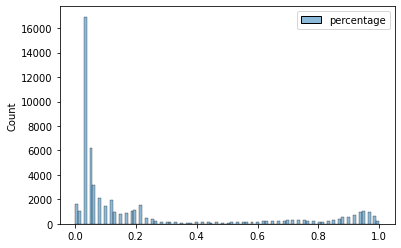

In [19]:
# the frequency of gene presence in other species than sauropsida
sns.histplot(gene_non_sauropsida_occurence)

In [20]:
# find percentage of occurence in reptiles and birds per gene
sauropsida = orthology_df.loc[(orthology_df["class"] == "Reptilia") | (orthology_df["class"] == "Aves")].drop(columns="class")
gene_sauropsida_occurence = get_gene_occurence(sauropsida)
gene_sauropsida_occurence

,percentage
0,0.250
1,0.000
2,0.625
3,0.750
4,0.625
...,...
54115,0.125
54116,0.000
54117,0.000
54118,0.000


<AxesSubplot:ylabel='Count'>

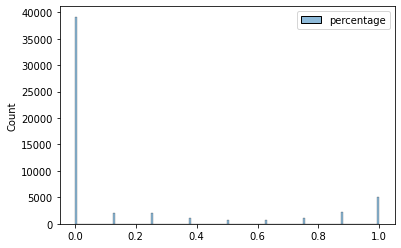

In [21]:
# the frequency of gene presence in sauropsida species
sns.histplot(gene_sauropsida_occurence)

In [22]:
# scoring function
# add score for high occurence in other taxa
# add score for high occurence in sauropsida
# TODO add/lower score for high ortholog GC content

def inititate_score_table(orth_df: pd.DataFrame):
    genes = orth_df.drop(columns=["class"]).columns.values.tolist()
    starting_scores = np.zeros(len(genes))
    score_table = pd.DataFrame({"scores": starting_scores}, index=genes)
    return score_table

In [23]:
# add taxa and non taxa occurence percentage to the score sum
def add_occurence_score(scores_df: pd.DataFrame, occur_df: pd.DataFrame):
    scores_df["scores"] = scores_df["scores"] + occur_df["percentage"]
    return scores_df

In [24]:
# prioritize gene to search for based on score
def get_genes_scores(ortho_df: pd.DataFrame):
    scores_df = inititate_score_table(ortho_df)
    # get gene occurence percentage in sauropsida
    sauropsida = orthology_df.loc[(orthology_df["class"] == "Reptilia") | (orthology_df["class"] == "Aves")].drop(columns="class")
    # get gene occurence outside of sauropsida
    non_sauropsida = orthology_df.loc[(orthology_df["class"] != "Reptilia") & (orthology_df["class"] != "Aves")].drop(columns="class")
    
    gene_sauropsida_occurence = get_gene_occurence(sauropsida)
    gene_non_sauropsida_occurence = get_gene_occurence(non_sauropsida)
    
    scores_df = add_occurence_score(scores_df, gene_sauropsida_occurence)
    scores_df = add_occurence_score(scores_df, gene_non_sauropsida_occurence)
    
    # todo add gc content info
    
    return scores_df

In [25]:
score_df = get_genes_scores(orthology_df)
score_df

,scores
0,1.100000
1,0.266667
2,1.191667
3,1.166667
4,1.258333
...,...
54115,0.141667
54116,0.033333
54117,0.033333
54118,0.033333


<AxesSubplot:ylabel='Count'>

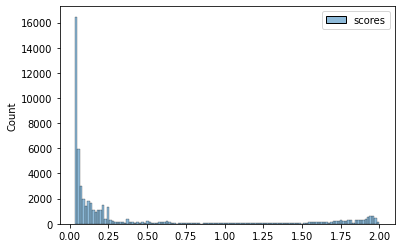

In [26]:
# gene score distribution
sns.histplot(score_df)

In [27]:
score_df[score_df["scores"] < 4.0]

,scores
0,1.100000
1,0.266667
2,1.191667
3,1.166667
4,1.258333
...,...
54115,0.141667
54116,0.033333
54117,0.033333
54118,0.033333


In [28]:
def filter_genes_with_all_orthologs_present(gene_scores: pd.DataFrame, ortho_df: pd.DataFrame):
    is_perfect_score_all_present = False
    max_score = gene_scores.values.max()
    index_highest_scoring_gene = gene_scores.loc[gene_scores["scores"] == max_score].index[0]
    if orthology_df[index_highest_scoring_gene].isna().sum() == 0:
        is_perfect_score_all_present = True
    # drop all rows with perfect score
    gene_scores = gene_scores[gene_scores["scores"] < max_score].copy(deep=True)
    return gene_scores

filtered_score_df = filter_genes_with_all_orthologs_present(score_df, orthology_df)
filtered_score_df

,scores
0,1.100000
1,0.266667
2,1.191667
3,1.166667
4,1.258333
...,...
54115,0.141667
54116,0.033333
54117,0.033333
54118,0.033333


In [30]:
# return a list of prioritized genes
# percentage: 0.1 -> returns 10% best scoring genes
# gene index id corresponds
def prirotize_gene_search(gene_scores: pd.DataFrame, percentage: float):
    max_score = gene_scores.values.max()
    gene_scores.sort_values("scores", ascending=False, inplace=True)
    number_of_genes = int(score_df.shape[0] * percentage)
    
    return gene_scores.iloc[:number_of_genes, :]

prioritized_score_df = prirotize_gene_search(filtered_score_df, 0.00185)
prioritized_score_df

,scores
7796,1.983333
9150,1.983333
9129,1.983333
9130,1.983333
8967,1.983333
...,...
9551,1.983333
7596,1.983333
7592,1.983333
9856,1.983333


In [31]:
missing_present_ensid_tuples = list()
prioritized_missing_genes = prioritized_score_df.index.tolist()

for gene in prioritized_missing_genes:
    organisms_with_missing = orthology_df.loc[orthology_df[gene].isna(), gene].index.tolist()
    for organism in organisms_with_missing:
        # preferably human (first in table -> index 0)
        organisms_with_present = orthology_df.loc[orthology_df[gene].notna(), gene].index.tolist()
        if len(organisms_with_present) > 0:
            organism_with_present = organisms_with_present[0]
        else:
            print("Gene is not present in any organism! No orthologs!")
            continue
        ensembl_id_ortholog = orthology_df.loc[organism_with_present, gene]
        
    missing_present_ensid_tuples.append((organism, organism_with_present, ensembl_id_ortholog))

In [32]:
missing_present_ensid_tuples

[('tetraodon_nigroviridis', 'homo_sapiens', 'ENSG00000004799'),
 ('astyanax_mexicanus', 'homo_sapiens', 'ENSG00000158987'),
 ('petromyzon_marinus', 'homo_sapiens', 'ENSG00000164187'),
 ('sorex_araneus', 'homo_sapiens', 'ENSG00000133101'),
 ('petromyzon_marinus', 'homo_sapiens', 'ENSG00000110395'),
 ('takifugu_rubripes', 'homo_sapiens', 'ENSG00000115339'),
 ('gasterosteus_aculeatus', 'homo_sapiens', 'ENSG00000124532'),
 ('mesocricetus_auratus', 'homo_sapiens', 'ENSG00000084652'),
 ('gadus_morhua', 'homo_sapiens', 'ENSG00000198963'),
 ('tetraodon_nigroviridis', 'homo_sapiens', 'ENSG00000134343'),
 ('petromyzon_marinus', 'homo_sapiens', 'ENSG00000152503'),
 ('jaculus_jaculus', 'homo_sapiens', 'ENSG00000170558'),
 ('ornithorhynchus_anatinus', 'homo_sapiens', 'ENSG00000178904'),
 ('petromyzon_marinus', 'homo_sapiens', 'ENSG00000164253'),
 ('petromyzon_marinus', 'homo_sapiens', 'ENSG00000092607'),
 ('heterocephalus_glaber_female', 'homo_sapiens', 'ENSG00000197006'),
 ('echinops_telfairi', 'h

In [33]:
def save_genes_to_search_to_json(genes_to_search: list):
    with open("genes_to_search_01_mar_23_100_genes", "w") as f:
        json.dump(genes_to_search, f)
        
save_genes_to_search_to_json(missing_present_ensid_tuples)

In [ ]:
# EVERYTHING BELOW IS WORK IN PROGRESS FOR GETTING GC CONTENT OF ORTHOLOGS FOR THE SCORING FUNCTION

```
# get GC content of all orthologs
def get_orthologs_json(ensembl_id: str):
    ext = f"/homology/id/{ensembl_id}"
    response = requests.get(ens_api+ext, headers={"Content-Type": "application/json"})
    response = response.json()
    return response
```

```
test_json = get_orthologs_json("ENSG00000278294")
test_json
```

```
# get list of orthologs ensembl ids from json
def get_orthologs_ensembl_ids_json(response: json):
    
    ensmebl_ids = []
    
    for i in range(0,len(response["data"][0]["homologies"])):
        ensembl_id = response["data"][0]["homologies"][i]["target"]["id"]
        ensmebl_ids.append(ensembl_id)
            
    return ensmebl_ids

json_orthologs = get_orthologs_ensembl_ids(test_json)
json_orthologs
```

```
def get_orthologs_ensembl_ids_from_table(ensembl_id: str, orth_df: pd.DataFrame):
    orthologs_ensembl_ids = orth_df.loc[:, ensembl_id].values.tolist()
    orthologs_ensembl_ids = [x for x in orthologs_ensembl_ids if not pd.isnull(x)]
    return orthologs_ensembl_ids
```

```
# get gc content of genes by ensembl id
def get_genes_GC_content(ensembl_ids: list):
    
    gc_contents = []
    
    for ens_id in ensembl_ids:
        try:
            gc = GC(gget.seq(ens_id)[1])
        except IndexError:
            continue
        gc_contents.append(gc)
        
    return gc_contents
```

```
for gene in orthology_df.columns.values.tolist():
    orthologs = get_orthologs_ensembl_ids_from_table(gene, orthology_df)
    gc_contents = get_genes_GC_content(orthologs)
    
gc_contents
```